In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np, pandas as pd

from datetime import date, timedelta
from typing import List
from tqdm.notebook import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os, gc, time, math, random
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/m5-fe-grids/lag_grid1 (1).pkl
/kaggle/input/m5-fe-grids/price_grid2 (1).pkl
/kaggle/input/m5-fe-grids/price_grid1 (1).pkl
/kaggle/input/m5-fe-grids/time_grid (1).pkl
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/basedf-m5/BASE_df (1).pkl


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.python.ops.linalg.sparse import sparse as tfsp
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer

In [3]:
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df

def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = [], verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    df = optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:3.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
#PATHS for Features
ORIGINAL = '../input/m5-forecasting-accuracy/'
BASE     = '/kaggle/input/basedf-m5/BASE_df (1).pkl'
PRICE1   = '/kaggle/input/m5-fe-grids/price_grid1 (1).pkl'
TIME     = '/kaggle/input/m5-fe-grids/time_grid (1).pkl'
LAGS     = '/kaggle/input/m5-fe-grids/lag_grid1 (1).pkl'
PRICE2   = '/kaggle/input/m5-fe-grids/price_grid2 (1).pkl'
SUB = ORIGINAL+'sample_submission.csv'

target = 'demand'
train_boundary = pd.datetime(2016, 1, 27)
valid_boundary = pd.datetime(2016, 2, 27)
test_boundary = pd.datetime(2016, 3, 27)
lgbm_epochs = 50
ESR = 150
VE = 10 
SEED = 657

In [5]:
def get_df():
    print('Loading from Pickle...')
    df = pd.read_pickle(BASE)
#     df = pd.concat([pd.read_pickle(BASE),
#                     pd.read_pickle(PRICE1).iloc[:,5:],
#                     pd.read_pickle(TIME).iloc[:,2:],
#                     pd.read_pickle(LAGS).iloc[:,2:],
#                     pd.read_pickle(PRICE2).iloc[:,2:]
#                    ],
#                     axis=1)
    return df

In [6]:
def mod_df(df): 
#     del df['Elapsed']
    df.sell_price.replace(np.nan, 0, inplace=True)
    df.amount.replace(np.nan, 0, inplace=True)
    df.dropna(inplace=True)
    df = optimize(df,['date'])
    gc.collect()
    return df

In [7]:
%%time
df = get_df()

Loading from Pickle...
CPU times: user 2.33 s, sys: 5.33 s, total: 7.65 s
Wall time: 8.02 s


In [8]:
%%time
df = mod_df(df)

Mem. usage decreased to 1436.73 Mb (60.5% reduction)
CPU times: user 19.2 s, sys: 8.42 s, total: 27.6 s
Wall time: 27.8 s


In [9]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'demand',
       'date', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'wholesale_inventory',
       'wholesale_sales', 'retai_t_f_sales', 'urban_cpi', 'cpi', 'unemp_rate',
       'ppi', 'gdp', 'sell_price', 'amount', 'outlier'],
      dtype='object')

In [16]:
gc.collect()

20

In [11]:
data = df[['item_id', 'store_id', 'demand', 'date']]
data = data.rename(columns={"item_id": "item", "store_id": "store"})

In [12]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical(df, cols):
    le = LabelEncoder()
    for col in cols:
        if col in df.columns:
            not_null = df[col][df[col].notnull()]
            df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)
    return df

data = encode_categorical(data, ['item'])

In [13]:
# data.tail()

In [17]:
### SWITCH DATA FROM VERTICAL TO HORIZONTAL FORMAT ###

unstaked_df = data.copy()
unstaked_df['id'] = data['item'].astype(str)+'_'+ data['store'].astype(str)
unstaked_df.set_index(['id','date'], inplace=True)
unstaked_df.drop(['store','item'], axis=1, inplace=True)
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

print(unstaked_df.shape) #(500, 1826)
unstaked_df.tail()

(30490, 914)


date,2013-10-24,2013-10-25,2013-10-26,2013-10-27,2013-10-28,2013-10-29,2013-10-30,2013-10-31,2013-11-01,2013-11-02,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
id,,,,,,,,,,,,,,,,,,,,,
9_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,5.0,3.0,0.0,1.0,0.0,1.0,0.0
9_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0
9_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
gc.collect()

20

In [19]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14
preds = 28

def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, 10, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, 10))

In [20]:
### PLOT A SEQUENCE OF SALES FOR ITEM 5 IN ALL STORES ###

# sequence = get_timespan(unstaked_df, date(2016,1,25), 30)
# sequence.head(5).T.plot(figsize=(14,5))
# plt.ylabel('demand')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [21]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = date(2016, 1, 25)
valid_date = date(2016, 2, 24)
test_date = date(2016, 3, 25)
end_date = date(2016, 4, 24)

In [22]:
### CREATE TRAIN FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train = np.concatenate(y, axis=0).astype('float16')

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)


(51833, 14, 10) (51833, 10, 10) (51833, 10, 7) (51833, 10)


In [23]:
gc.collect()

27

In [24]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid = np.concatenate(y, axis=0).astype('float16')

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)


(51833, 14, 10) (51833, 10, 10) (51833, 10, 7) (51833, 10)


In [25]:
gc.collect()

27

In [26]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), end_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test = np.concatenate(y, axis=0).astype('float16')

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)


(51833, 14, 10) (51833, 10, 10) (51833, 10, 7) (51833, 10)


In [27]:
gc.collect()

27

In [28]:
### SCALE SEQUENCES ###

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,10)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,10)).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1,10)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,10)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,10)).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,10)).reshape(X_test_feat.shape)

In [29]:
gc.collect()

20

In [30]:
from scipy import sparse as sp

SINGLE  = 1   # Single         (rank(a)=2, rank(b)=2)
MIXED   = 2   # Mixed          (rank(a)=2, rank(b)=3)
iMIXED  = 3   # Inverted mixed (rank(a)=3, rank(b)=2)
BATCH   = 4   # Batch          (rank(a)=3, rank(b)=3)
UNKNOWN = -1  # Unknown


def transpose(a, perm=None, name=None):
    """
    Transposes a according to perm, dealing automatically with sparsity.
    :param a: Tensor or SparseTensor with rank k.
    :param perm: permutation indices of size k.
    :param name: name for the operation.
    :return: Tensor or SparseTensor with rank k.
    """
    if K.is_sparse(a):
        transpose_op = tf.sparse.transpose
    else:
        transpose_op = tf.transpose

    if perm is None:
        perm = (1, 0)  # Make explicit so that shape will always be preserved
    return transpose_op(a, perm=perm, name=name)


def reshape(a, shape=None, name=None):
    """
    Reshapes a according to shape, dealing automatically with sparsity.
    :param a: Tensor or SparseTensor.
    :param shape: new shape.
    :param name: name for the operation.
    :return: Tensor or SparseTensor.
    """
    if K.is_sparse(a):
        reshape_op = tf.sparse.reshape
    else:
        reshape_op = tf.reshape

    return reshape_op(a, shape=shape, name=name)


def autodetect_mode(a, b):
    """
    Return a code identifying the mode of operation (single, mixed, inverted mixed and
    batch), given a and b. See `ops.modes` for meaning of codes.
    :param a: Tensor or SparseTensor.
    :param b: Tensor or SparseTensor.
    :return: mode of operation as an integer code.
    """
    a_dim = K.ndim(a)
    b_dim = K.ndim(b)
    if b_dim == 2:
        if a_dim == 2:
            return SINGLE
        elif a_dim == 3:
            return iMIXED
    elif b_dim == 3:
        if a_dim == 2:
            return MIXED
        elif a_dim == 3:
            return BATCH
    return UNKNOWN


def filter_dot(fltr, features):
    """
    Wrapper for matmul_A_B, specifically used to compute the matrix multiplication
    between a graph filter and node features.
    :param fltr:
    :param features: the node features (N x F in single mode, batch x N x F in
    mixed and batch mode).
    :return: the filtered features.
    """
    mode = autodetect_mode(fltr, features)
    if mode == SINGLE or mode == BATCH:
        return dot(fltr, features)
    else:
        # Mixed mode
        return mixed_mode_dot(fltr, features)


def dot(a, b, transpose_a=False, transpose_b=False):
    """
    Dot product between a and b along innermost dimensions, for a and b with
    same rank. Supports both dense and sparse multiplication (including
    sparse-sparse).
    :param a: Tensor or SparseTensor with rank 2 or 3.
    :param b: Tensor or SparseTensor with same rank as a.
    :param transpose_a: bool, transpose innermost two dimensions of a.
    :param transpose_b: bool, transpose innermost two dimensions of b.
    :return: Tensor or SparseTensor with rank 2 or 3.
    """
    a_is_sparse_tensor = isinstance(a, tf.SparseTensor)
    b_is_sparse_tensor = isinstance(b, tf.SparseTensor)
    if a_is_sparse_tensor:
        a = tfsp.CSRSparseMatrix(a)
    if b_is_sparse_tensor:
        b = tfsp.CSRSparseMatrix(b)
    out = tfsp.matmul(a, b, transpose_a=transpose_a, transpose_b=transpose_b)
    if hasattr(out, 'to_sparse_tensor'):
        return out.to_sparse_tensor()

    return out


def mixed_mode_dot(a, b):
    """
    Computes the equivalent of `tf.einsum('ij,bjk->bik', a, b)`, but
    works for both dense and sparse input filters.
    :param a: rank 2 Tensor or SparseTensor.
    :param b: rank 3 Tensor or SparseTensor.
    :return: rank 3 Tensor or SparseTensor.
    """
    s_0_, s_1_, s_2_ = K.int_shape(b)
    B_T = transpose(b, (1, 2, 0))
    B_T = reshape(B_T, (s_1_, -1))
    output = dot(a, B_T)
    output = reshape(output, (s_1_, s_2_, -1))
    output = transpose(output, (2, 0, 1))

    return output


def degree_power(A, k):
    r"""
    Computes \(\D^{k}\) from the given adjacency matrix. Useful for computing
    normalised Laplacian.
    :param A: rank 2 array or sparse matrix.
    :param k: exponent to which elevate the degree matrix.
    :return: if A is a dense array, a dense array; if A is sparse, a sparse
    matrix in DIA format.
    """
    degrees = np.power(np.array(A.sum(1)), k).flatten()
    degrees[np.isinf(degrees)] = 0.
    if sp.issparse(A):
        D = sp.diags(degrees)
    else:
        D = np.diag(degrees)
    return D


def normalized_adjacency(A, symmetric=True):
    r"""
    Normalizes the given adjacency matrix using the degree matrix as either
    \(\D^{-1}\A\) or \(\D^{-1/2}\A\D^{-1/2}\) (symmetric normalization).
    :param A: rank 2 array or sparse matrix;
    :param symmetric: boolean, compute symmetric normalization;
    :return: the normalized adjacency matrix.
    """
    if symmetric:
        normalized_D = degree_power(A, -0.5)
        output = normalized_D.dot(A).dot(normalized_D)
    else:
        normalized_D = degree_power(A, -1.)
        output = normalized_D.dot(A)
    return output


def localpooling_filter(A, symmetric=True):
    r"""
    Computes the graph filter described in
    [Kipf & Welling (2017)](https://arxiv.org/abs/1609.02907).
    :param A: array or sparse matrix with rank 2 or 3;
    :param symmetric: boolean, whether to normalize the matrix as
    \(\D^{-\frac{1}{2}}\A\D^{-\frac{1}{2}}\) or as \(\D^{-1}\A\);
    :return: array or sparse matrix with rank 2 or 3, same as A;
    """
    fltr = A.copy()
    if sp.issparse(A):
        I = sp.eye(A.shape[-1], dtype=A.dtype)
    else:
        I = np.eye(A.shape[-1], dtype=A.dtype)
    if A.ndim == 3:
        for i in range(A.shape[0]):
            A_tilde = A[i] + I
            fltr[i] = normalized_adjacency(A_tilde, symmetric=symmetric)
    else:
        A_tilde = A + I
        fltr = normalized_adjacency(A_tilde, symmetric=symmetric)

    if sp.issparse(fltr):
        fltr.sort_indices()
    return fltr

In [31]:
### OBTAIN LAPLACIANS FROM CORRELATIONS ###

X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [32]:
X_train_lap = np.nan_to_num(X_train_lap) 
X_valid_lap = np.nan_to_num(X_valid_lap) 
X_test_lap = np.nan_to_num(X_test_lap) 

In [33]:
gc.collect()

60

In [34]:
class GraphConv(Layer):
    r"""
    A graph convolutional layer (GCN) as presented by
    [Kipf & Welling (2016)](https://arxiv.org/abs/1609.02907).
    **Mode**: single, mixed, batch.
    This layer computes:
    $$
        \Z = \hat \D^{-1/2} \hat \A \hat \D^{-1/2} \X \W + \b
    $$
    where \( \hat \A = \A + \I \) is the adjacency matrix with added self-loops
    and \(\hat\D\) is its degree matrix.
    **Input**
    - Node features of shape `([batch], N, F)`;
    - Modified Laplacian of shape `([batch], N, N)`; can be computed with
    `spektral.utils.convolution.localpooling_filter`.
    **Output**
    - Node features with the same shape as the input, but with the last
    dimension changed to `channels`.
    **Arguments**
    - `channels`: number of output channels;
    - `activation`: activation function to use;
    - `use_bias`: whether to add a bias to the linear transformation;
    - `kernel_initializer`: initializer for the kernel matrix;
    - `bias_initializer`: initializer for the bias vector;
    - `kernel_regularizer`: regularization applied to the kernel matrix;
    - `bias_regularizer`: regularization applied to the bias vector;
    - `activity_regularizer`: regularization applied to the output;
    - `kernel_constraint`: constraint applied to the kernel matrix;
    - `bias_constraint`: constraint applied to the bias vector.
    """

    def __init__(self,
                 channels,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):

        super().__init__(activity_regularizer=activity_regularizer, **kwargs)
        self.channels = channels
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.supports_masking = False

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[0][-1]
        self.kernel = self.add_weight(shape=(input_dim, self.channels),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.channels,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs):
        features = inputs[0]
        fltr = inputs[1]

        # Convolution
        output = dot(features, self.kernel)
        output = filter_dot(fltr, output)

        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        features_shape = input_shape[0]
        output_shape = features_shape[:-1] + (self.channels,)
        return output_shape

    def get_config(self):
        config = {
            'channels': self.channels,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @staticmethod
    def preprocess(A):
        return localpooling_filter(A)

In [35]:
def get_model():

    opt = Adam(lr=0.001)

    inp_seq = Input((sequence_length, 10))
    inp_lap = Input((10, 10))
    inp_feat = Input((10, X_train_feat.shape[-1]))

    x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
    x = GraphConv(16, activation='relu')([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(optimizer=opt, loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [36]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 10)]     0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 10, 32)       256         input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 14, 10)]     0                                        

In [37]:
gc.collect()

20

In [38]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###


tf.random.set_seed(43)
os.environ['PYTHONHASHSEED'] = str(43)
np.random.seed(43)
random.seed(43)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

for store in range(10):

    print('-------', 'store', store, '-------')
    
    es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

    model = get_model()
    model.fit([X_train_seq, X_train_lap, X_train_feat], y_train[:,store], epochs=100, batch_size=256, 
              validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:,store]), callbacks=[es], verbose=2)

    pred_valid_all[:,store] = model.predict([X_valid_seq, X_valid_lap, X_valid_feat]).ravel()
    pred_test_all[:,store] = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()


pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all = scaler_seq.inverse_transform(pred_test_all)
reverse_test = scaler_seq.inverse_transform(y_test)

------- store 0 -------
Train on 51833 samples, validate on 51833 samples
Epoch 1/100
51833/51833 - 11s - loss: 0.6126 - root_mean_squared_error: 0.7827 - val_loss: 0.6035 - val_root_mean_squared_error: 0.7768
Epoch 2/100
51833/51833 - 7s - loss: 0.5099 - root_mean_squared_error: 0.7141 - val_loss: 0.5379 - val_root_mean_squared_error: 0.7334
Epoch 3/100
51833/51833 - 7s - loss: 0.5094 - root_mean_squared_error: 0.7137 - val_loss: 0.5377 - val_root_mean_squared_error: 0.7333
Epoch 4/100
51833/51833 - 7s - loss: 0.4703 - root_mean_squared_error: 0.6858 - val_loss: 0.5637 - val_root_mean_squared_error: 0.7508
Epoch 5/100
51833/51833 - 8s - loss: 0.4715 - root_mean_squared_error: 0.6867 - val_loss: 0.5083 - val_root_mean_squared_error: 0.7129
Epoch 6/100
51833/51833 - 7s - loss: 0.4481 - root_mean_squared_error: 0.6694 - val_loss: 0.5440 - val_root_mean_squared_error: 0.7375
Epoch 7/100
51833/51833 - 7s - loss: 0.4456 - root_mean_squared_error: 0.6675 - val_loss: 0.4970 - val_root_mean_sq

Epoch 7/100
51833/51833 - 7s - loss: 0.5506 - root_mean_squared_error: 0.7420 - val_loss: 0.5651 - val_root_mean_squared_error: 0.7518
Epoch 8/100
51833/51833 - 7s - loss: 0.5292 - root_mean_squared_error: 0.7275 - val_loss: 0.6075 - val_root_mean_squared_error: 0.7794
Epoch 9/100
51833/51833 - 7s - loss: 0.5320 - root_mean_squared_error: 0.7294 - val_loss: 0.6223 - val_root_mean_squared_error: 0.7888
Epoch 10/100
51833/51833 - 7s - loss: 0.5480 - root_mean_squared_error: 0.7402 - val_loss: 0.5837 - val_root_mean_squared_error: 0.7640
Epoch 11/100
51833/51833 - 7s - loss: 0.5404 - root_mean_squared_error: 0.7351 - val_loss: 0.6195 - val_root_mean_squared_error: 0.7871
Epoch 12/100
51833/51833 - 7s - loss: 0.5311 - root_mean_squared_error: 0.7288 - val_loss: 0.5639 - val_root_mean_squared_error: 0.7509
Epoch 13/100
51833/51833 - 8s - loss: 0.5397 - root_mean_squared_error: 0.7346 - val_loss: 0.5723 - val_root_mean_squared_error: 0.7565
Epoch 14/100
51833/51833 - 7s - loss: 0.5397 - root

Epoch 3/100
51833/51833 - 7s - loss: 0.5696 - root_mean_squared_error: 0.7547 - val_loss: 0.7009 - val_root_mean_squared_error: 0.8372
Epoch 4/100
51833/51833 - 7s - loss: 0.5596 - root_mean_squared_error: 0.7481 - val_loss: 0.6224 - val_root_mean_squared_error: 0.7889
Epoch 5/100
51833/51833 - 7s - loss: 0.5353 - root_mean_squared_error: 0.7317 - val_loss: 0.6028 - val_root_mean_squared_error: 0.7764
Epoch 6/100
51833/51833 - 7s - loss: 0.5217 - root_mean_squared_error: 0.7223 - val_loss: 0.6094 - val_root_mean_squared_error: 0.7807
Epoch 7/100
51833/51833 - 7s - loss: 0.5150 - root_mean_squared_error: 0.7176 - val_loss: 0.5605 - val_root_mean_squared_error: 0.7487
Epoch 8/100
51833/51833 - 7s - loss: 0.5237 - root_mean_squared_error: 0.7237 - val_loss: 1.3613 - val_root_mean_squared_error: 1.1667
Epoch 9/100
51833/51833 - 7s - loss: 0.4956 - root_mean_squared_error: 0.7040 - val_loss: 0.6197 - val_root_mean_squared_error: 0.7872
Epoch 10/100
51833/51833 - 7s - loss: 0.4852 - root_mea

In [39]:
### RMSE ON TEST DATA ###

error = {}

for store in range(10):
    
    error[store] = np.sqrt(mean_squared_error(np.nan_to_num(reverse_test[:,store]), np.nan_to_num(pred_test_all[:,store])))

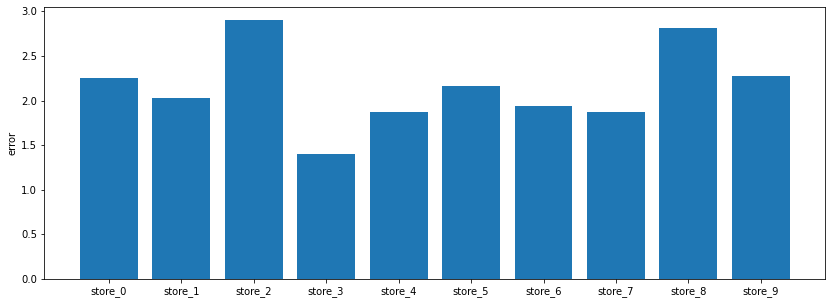

In [40]:
### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(10), error.values())
plt.xticks(range(10), ['store_'+str(s) for s in range(10)])
plt.ylabel('error')
np.set_printoptions(False)

In [41]:
### UTILITY FUNCTION TO PLOT PREDICTION ###

def plot_predictions(y_true, y_pred, store, item):
    
    y_true = y_true.reshape(17,-1,10)
    y_pred = y_pred.reshape(17,-1,10)
    
    plt.plot(y_true[item,:,store], label='true')
    plt.plot(y_pred[item,:,store], label='prediction')
    plt.title(f"store: {store} item: {item}"); plt.legend()
    plt.ylabel('sales'); plt.xlabel('date')

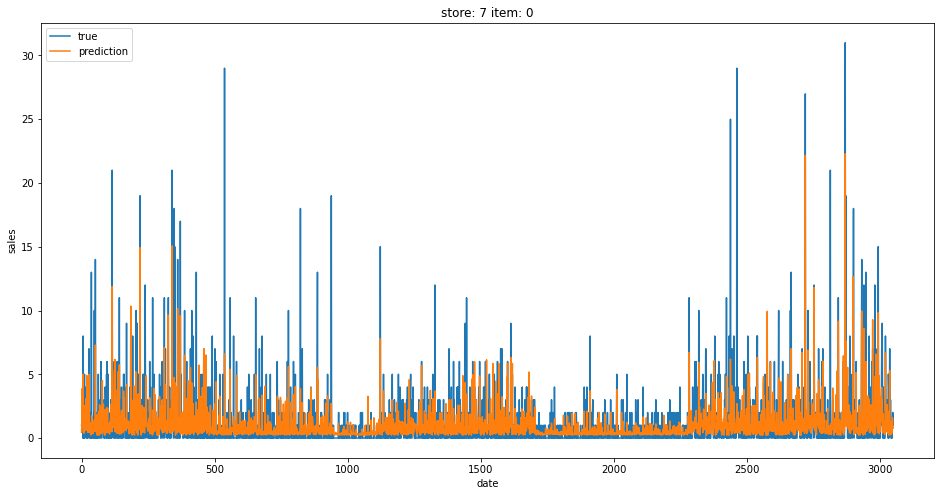

In [47]:
plt.figure(figsize=(16,8))
plot_predictions(reverse_test, pred_test_all, 7,0)

In [45]:
pred = pd.DataFrame(pred_test_all)

In [46]:
pred

,0,1,2,3,4,5,6,7,8,9
0,0.700993,0.432896,0.891460,0.435863,0.352793,0.635784,0.609717,0.451382,0.586658,0.487128
1,1.177850,1.053261,1.427621,0.559682,0.777166,1.080265,1.363251,1.019434,1.924739,1.091108
2,8.164149,8.090981,12.652498,3.140986,7.526997,9.518074,7.068919,3.870133,7.023416,7.693882
3,1.203772,1.330717,1.438843,0.718248,1.076794,1.133574,1.466178,1.233984,2.233414,1.057567
4,2.119315,1.746327,1.742139,0.979270,0.741657,0.946054,1.025805,0.995133,0.823023,0.964328
...,...,...,...,...,...,...,...,...,...,...
51828,0.908225,1.471573,1.672109,0.689938,0.797465,0.966894,1.219324,0.973028,1.025428,0.951968
51829,1.631014,1.749050,1.756257,0.913362,0.592316,0.931582,0.967941,1.297542,1.926301,1.078042
51830,1.940750,1.748400,1.775588,1.185131,0.744416,1.089240,1.351902,1.191944,1.742304,0.970126
51831,0.690690,0.692656,1.029042,0.503446,0.759496,0.888176,1.141962,0.860457,1.374502,0.770713
